In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

# **Задание**

с платформы Kaggle датасет о продажах различных вымышленных учебных модулей в течение всего года в разных вымышленных магазинах под брендом Kaggle в разных (реальных!) странах.

**задание** - спрогнозировать продажи в течение 2022 года, используя модель на основе LSTM для прогнозирования будущих значений



In [ ]:
train_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1MGbSzi_CgAhukMF01vAEMcSVvZg-AbL9', index_col="id", parse_dates=["date"])

In [ ]:
train_data.head()

,date,country,store,product,num_sold
id,,,,,
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      136950 non-null  datetime64[ns]
 1   country   136950 non-null  object        
 2   store     136950 non-null  object        
 3   product   136950 non-null  object        
 4   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.3+ MB


In [ ]:
# проверка пропущенных
missing_values = train_data.isnull().sum()

# Распределение продаж по странам
sales_per_country = train_data.groupby('country')['num_sold'].sum()

# Распределение продаж по магазинам
sales_per_store = train_data.groupby('store')['num_sold'].sum()

# Распределение продаж по продукту
sales_per_product = train_data.groupby('product')['num_sold'].sum()

# диапозон времени
time_range = train_data['date'].agg(['min', 'max'])

missing_values, sales_per_country, sales_per_store, sales_per_product, time_range

(date        0
 country     0
 store       0
 product     0
 num_sold    0
 dtype: int64,
 country
 Argentina    1683244
 Canada       7013114
 Estonia      3577319
 Japan        6013786
 Spain        4380862
 Name: num_sold, dtype: int64,
 store
 Kagglazon       15661335
 Kaggle Learn     2755934
 Kaggle Store     4251056
 Name: num_sold, dtype: int64,
 product
 Using LLMs to Improve Your Coding                 6069281
 Using LLMs to Train More LLMs                     5993975
 Using LLMs to Win Friends and Influence People     932564
 Using LLMs to Win More Kaggle Competitions        5068313
 Using LLMs to Write Better                        4604192
 Name: num_sold, dtype: int64,
 min   2017-01-01
 max   2021-12-31
 Name: date, dtype: datetime64[ns])

__Пропущенные значения__: отсутствуют

__Продажи по странам__:

- Аргентина: 1 683 244
- Канада: 7 013 114
- Эстония: 3 577 319
- Япония: 6 013 786
- Испания: 4 380 862

__Продажи на один магазин__:

- Каглазон: 15 661 335
- Kaggle Learn: 2 755 934
- Kaggle Store: 4 251 056

__Продажи на один продукт__:

- Использование LLM для улучшения кодирования: 6 069 281
- Использование LLM для обучения большего числа LLM: 5 993 975
- Использование LLM для завоевания друзей и влияния на людей: 932 564
- Использование LLM для победы в соревнованиях Kaggle: 5 068 313
- Использование LLM для того, чтобы писать лучше: 4 604 192

__Временной диапазон__: от 1 января 2017 года по 31 декабря 2021 года.

In [ ]:
distribution_sold = train_data.groupby('date')['num_sold'].sum() # распределение по дате, суммирование продаж за день. нужен для визуализации

<Axes: xlabel='date', ylabel='num_sold'>

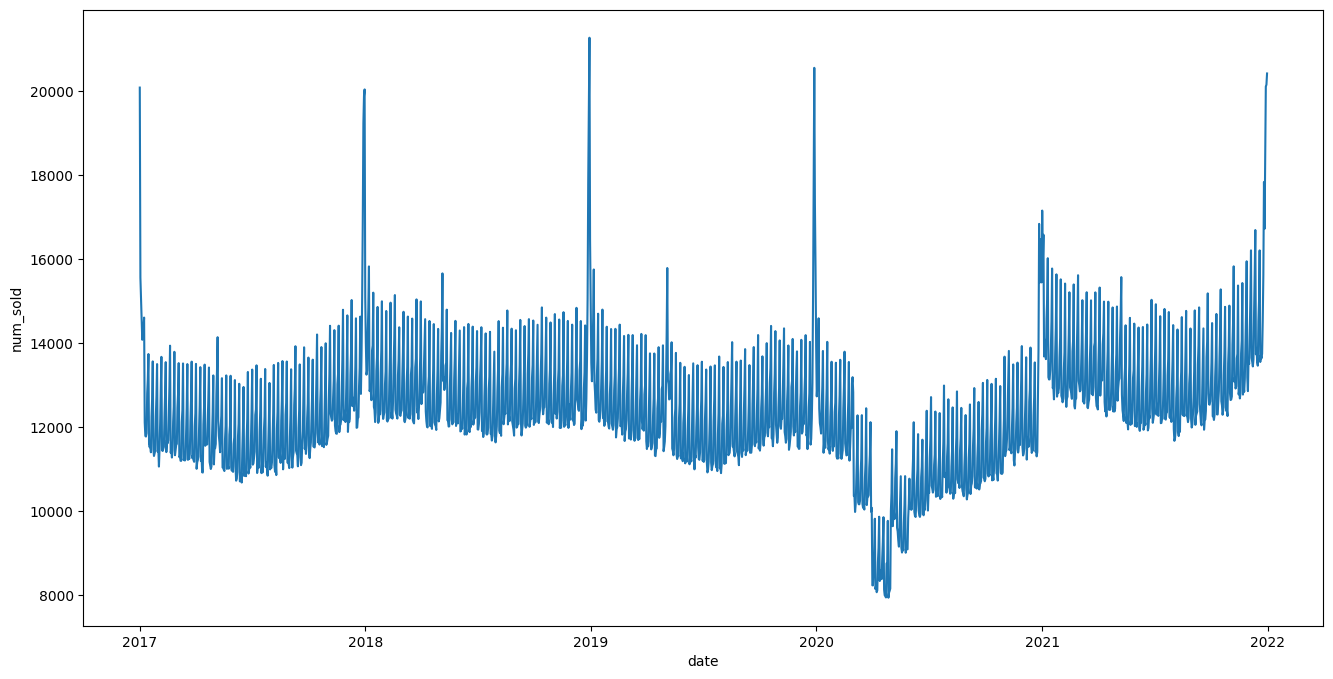

In [ ]:
fig = plt.figure(figsize=(16, 8))
sns.lineplot(data=distribution_sold)

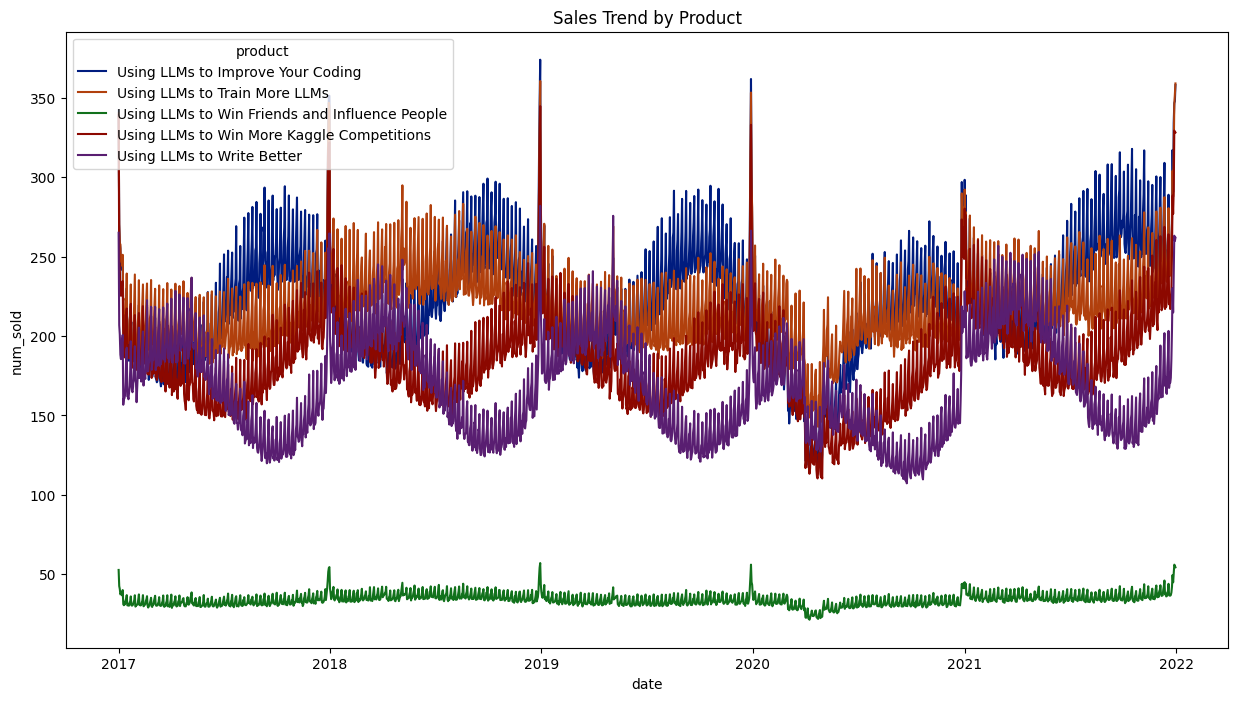

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=train_data,x='date',y='num_sold',hue='product',palette='dark',ci=None)
plt.title("Sales Trend by Product")
plt.show()

Для каждого продукта наблюдается тенденция  синусоидальной продажи, так и косинусоидальной, что указывает на цикличность.

видны отчетливые пики продаж, которые совпадают с сезонами отпусков.

2020 год будет другим из-за covid.

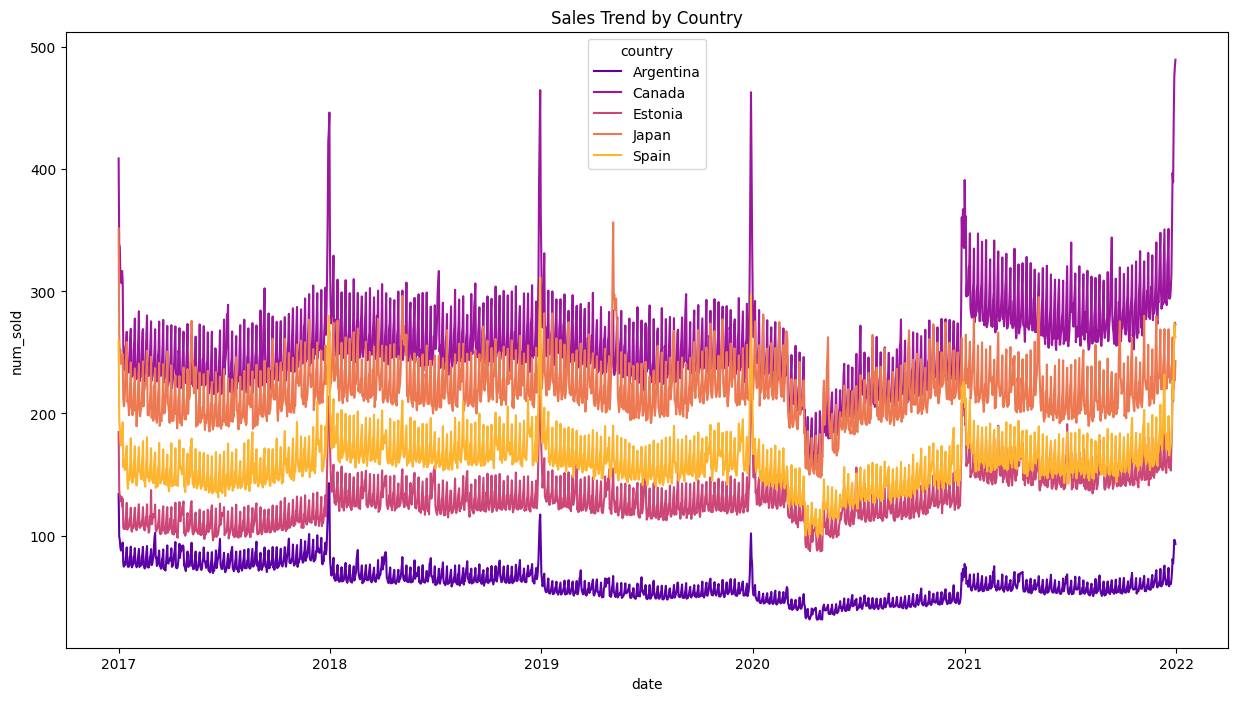

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=train_data,x='date',y='num_sold',hue='country',palette = 'plasma',ci=None)
plt.title("Sales Trend by Country")
plt.show()

Динамика у стран примерно одинаковая, но количество продаж общее различается.

Лучше всего с продажами в Канаде, а хуже в Аргентине.

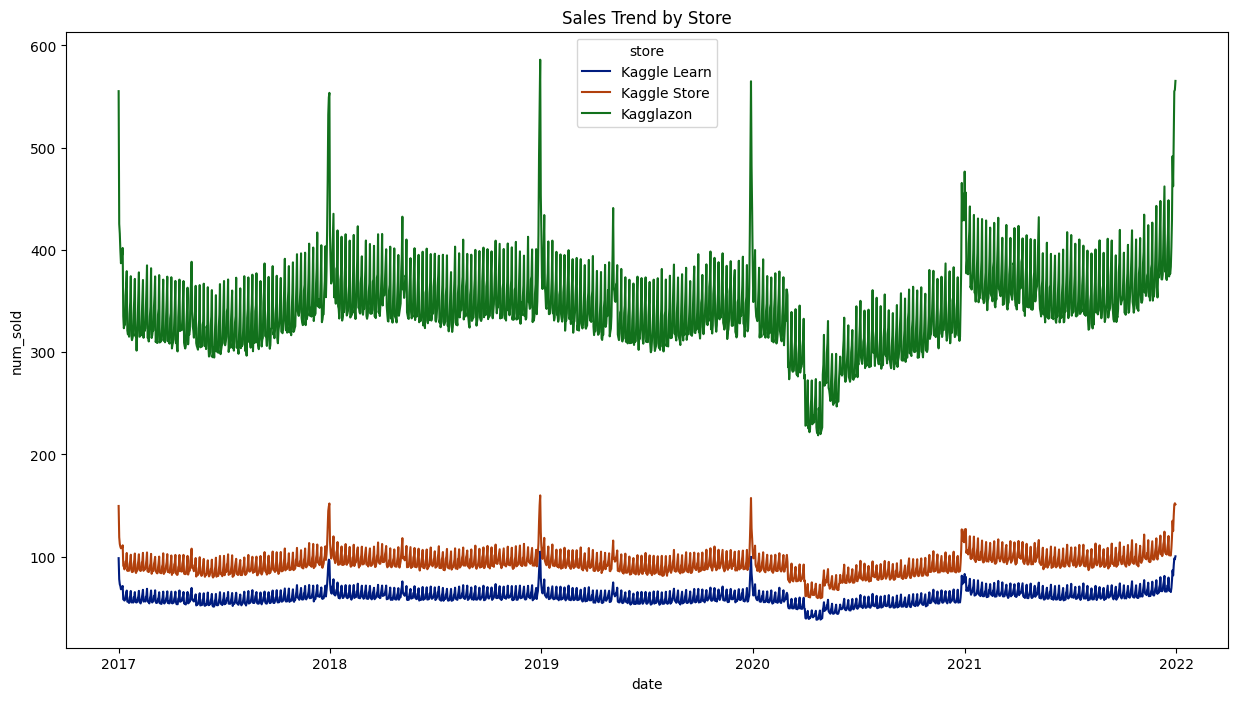

In [ ]:
plt.figure(figsize=(15,8))
sns.lineplot(data=train_data,x='date',y='num_sold',hue='store',palette='dark',ci=None)
plt.title("Sales Trend by Store")
plt.show()

Kagglazon оказывается лучшим и имеет больше всего продаж но и более заметные изменения. Возможно этот магазин имеет большую популярность и имеет более обширную сеть.

## *Подготовка данных*

- тест дики- фуллера
- проверка сезонности
- разделение на обучающую и тестовую выборки

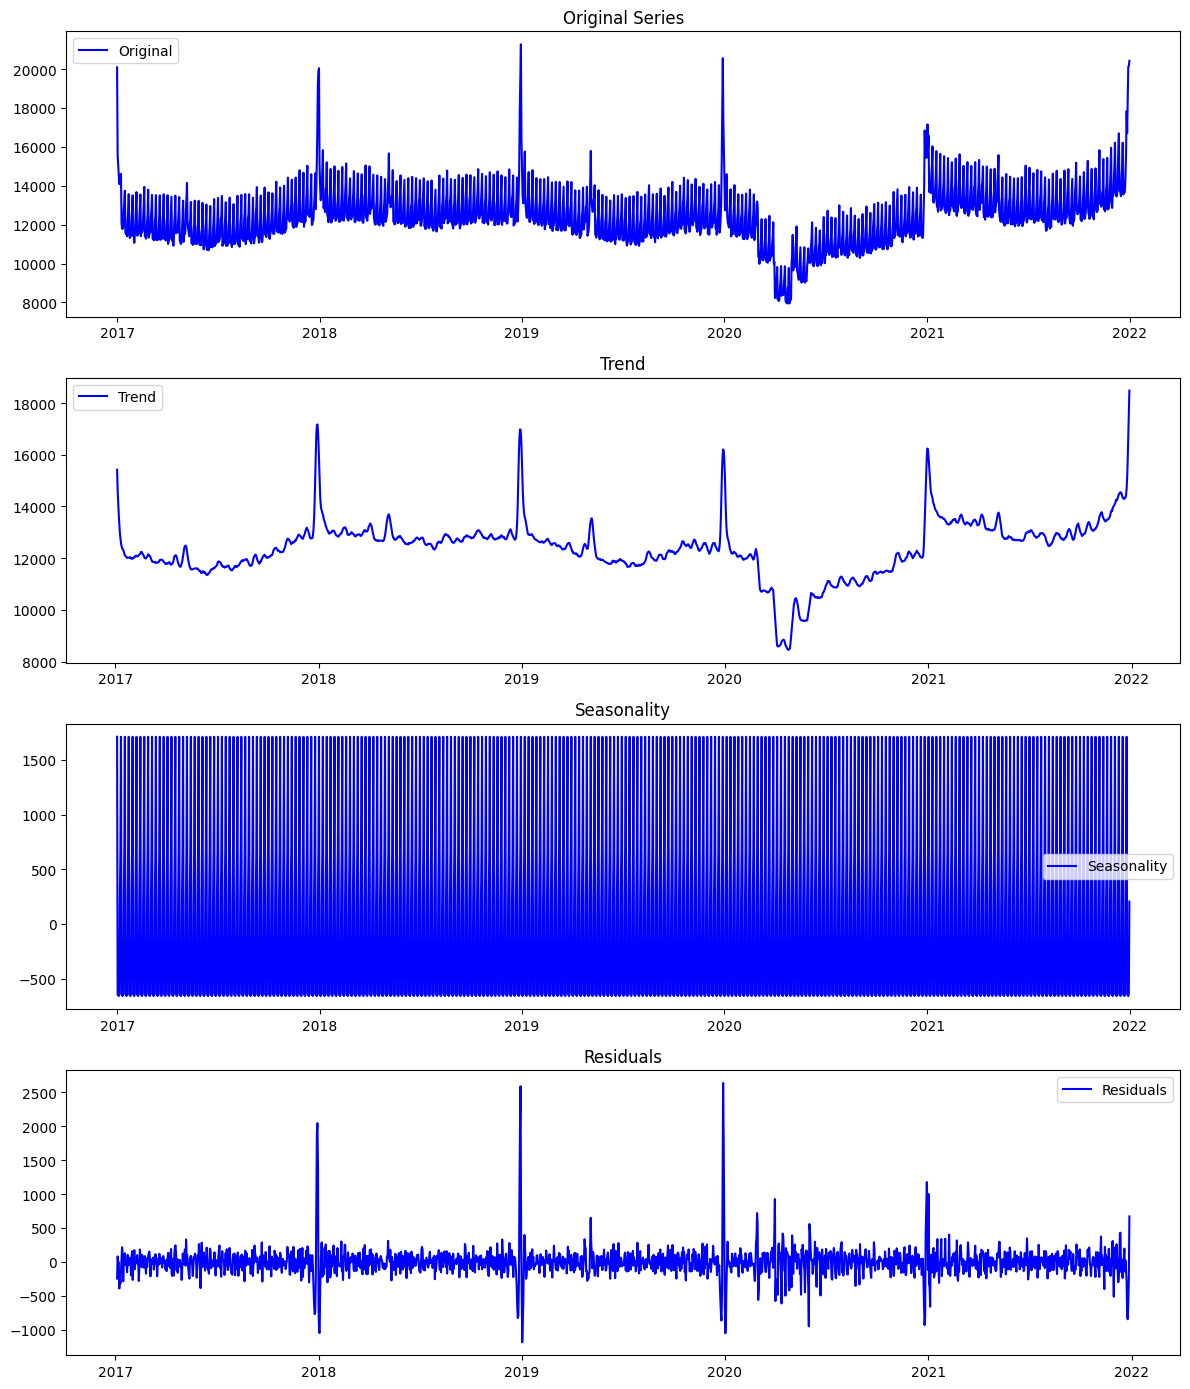

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(distribution_sold, model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 14))

# распределение
ax1.plot(distribution_sold, label='Original', color='blue')
ax1.legend(loc='best')
ax1.set_title('Original Series')

# Тренд
ax2.plot(decomposition.trend, label='Trend', color='blue')
ax2.legend(loc='best')
ax2.set_title('Trend')

# Сезонность
ax3.plot(decomposition.seasonal, label='Seasonality', color='blue')
ax3.legend(loc='best')
ax3.set_title('Seasonality')

# Остатки
ax4.plot(decomposition.resid, label='Residuals', color='blue')
ax4.legend(loc='best')
ax4.set_title('Residuals')

plt.tight_layout()
plt.show()

**Тренд**: Компонент тренда показывает общую тенденцию роста продаж с течением времени, что свидетельствует о том, что продажи в целом растут с течением времени.

**Сезонность**: В данных прослеживается четкая сезонность. Пик продаж приходится на одно и то же время каждый год, что может быть связано с такими факторами, как ежегодные мероприятия по продажам, праздники и т.д.

**Остатки**: Остатки показывают оставшуюся вариацию данных после удаления тренда и сезонных компонентов. Похоже, что они имеют постоянную дисперсию с течением времени, что является хорошим признаком.

проверка теста Дики-Фуллера

тест даст  p-value, и если p-value меньше 0,05, то можно отвергнуть нулевую гипотезу о нестационарности временного ряда и предположить, что он стационарен. В противном случае, прежде чем применять какие-либо модели прогнозирования временного ряда, необходимо сделать его стационарным.

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(distribution_sold.values)
adf_p_value = adf_result[1]

adf_p_value

0.6488107600677883

отвергаем нулевую гипотезу о том, что временной ряд нестационарен.

Надо преобразовать данные, чтобы сделать их стационарными.

In [ ]:
distribution_sold_diff = distribution_sold.diff().dropna()
adf_result_diff = adfuller(distribution_sold_diff.values)

adf_diff = adf_result_diff[1]

adf_diff


3.137881084600663e-22

Таким образом, мы можем отвергнуть нулевую гипотезу и предположить, что дифференцированный временной ряд является стационарным.

**График автокорреляции**

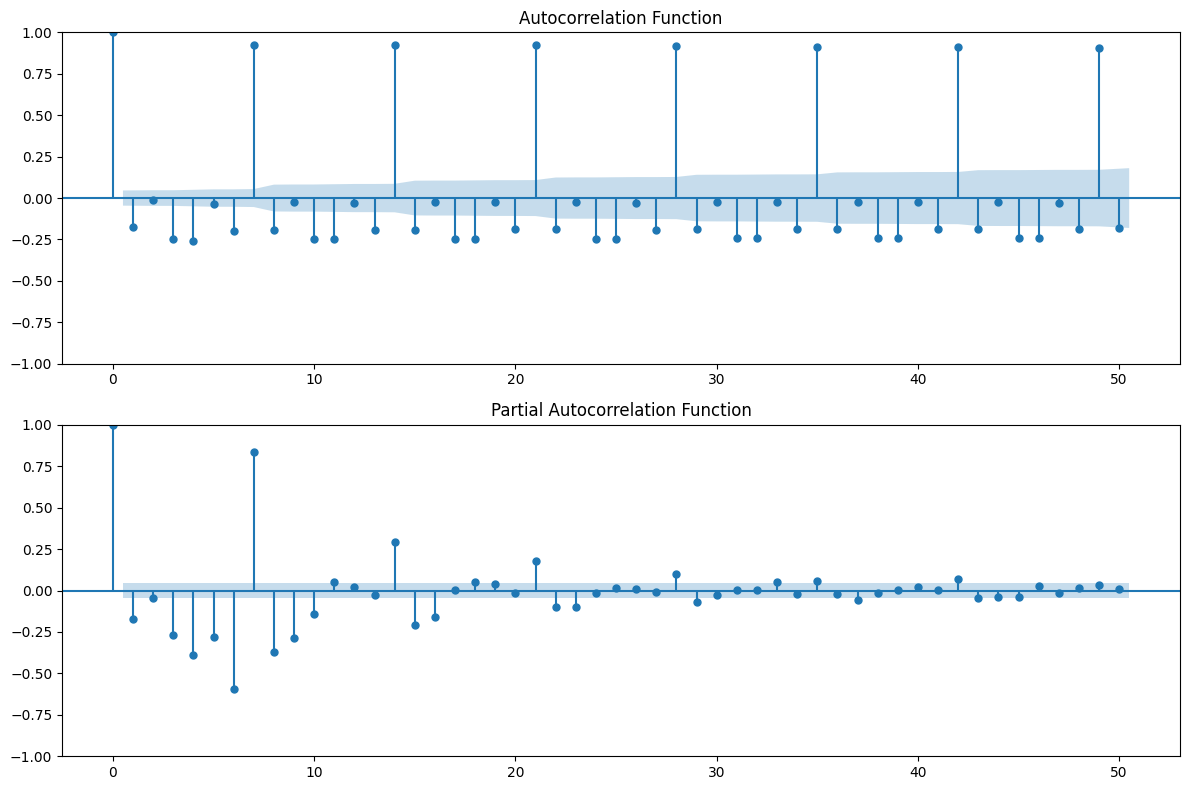

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF
plot_acf(distribution_sold_diff, lags=50, ax=ax1)
ax1.set_title('Autocorrelation Function')

# PACF
plot_pacf(distribution_sold_diff, lags=50, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

**ACF** показывает значительную автокорреляцию на многих лагах. Это указывает на то, что продажи коррелируют со своими прошлыми значениями.

**PACF** показывает значительную автокорреляцию на первых нескольких лагах, но после этого она становится незначительной. Частичная автокорреляция дает частичную корреляцию временного ряда с его собственными лагами, т.е. корреляцию на лаге k, которая не объясняется лагами с 1 по k-1.

Надо поработать с датафреймом, попробовать разложить данные о продуктах, странах и магазинах по столбцам, вычленить из даты доп информацию.

In [ ]:
train_df = train_data.copy(deep=True)

In [ ]:
categorical_features = ['country', 'store', 'product']
encoded_features = pd.get_dummies(train_df[categorical_features])

# удаление исходных категориальных и добавление закодированных признаков.
train_df = train_df.drop(categorical_features, axis=1)
train_df = pd.concat([train_df, encoded_features], axis=1)

# Извлечение доп информации из даты
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day_of_week'] = train_df['date'].dt.dayofweek

train_df = train_df.drop(columns=['date'])


train_df.head()

,num_sold,country_Argentina,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,year,month,day_of_week
id,,,,,,,,,,,,,,,,,
0,63,1,0,0,0,0,0,1,0,1,0,0,0,0,2017,1,6
1,66,1,0,0,0,0,0,1,0,0,1,0,0,0,2017,1,6
2,9,1,0,0,0,0,0,1,0,0,0,1,0,0,2017,1,6
3,59,1,0,0,0,0,0,1,0,0,0,0,1,0,2017,1,6
4,49,1,0,0,0,0,0,1,0,0,0,0,0,1,2017,1,6


Разделение на обучающую и валидационную выборку

In [ ]:
X = train_df.drop(columns=['num_sold'])
y = train_df['num_sold']

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, shuffle=False, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((109560, 16), (109560,), (27390, 16), (27390,))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_train_normalized = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_normalized = scaler.fit_transform(y_val.values.reshape(-1, 1))

## *Построение модели LSTM*

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [ ]:
model = Sequential()

model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(16, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Компиляция модели с оптимизатором 'adam' и функцией потерь 'mean_squared_error'
model.compile(optimizer='adam', loss='mean_squared_error')

## *Обучение модели.*



In [ ]:
model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs = 10, batch_size = 32)

Epoch 1/10
3424/3424 [==============================] - 135s 38ms/step - loss: 18254.0781 - val_loss: 15921.9893
Epoch 2/10
3424/3424 [==============================] - 124s 36ms/step - loss: 8544.3135 - val_loss: 12072.4160
Epoch 3/10
3424/3424 [==============================] - 121s 35ms/step - loss: 7016.8428 - val_loss: 6205.2744
Epoch 4/10
3424/3424 [==============================] - 123s 36ms/step - loss: 11777.9951 - val_loss: 15010.2754
Epoch 5/10
3424/3424 [==============================] - 122s 36ms/step - loss: 12674.1279 - val_loss: 13152.5771
Epoch 6/10
3424/3424 [==============================] - 125s 36ms/step - loss: 10480.4023 - val_loss: 13213.0439
Epoch 7/10
3424/3424 [==============================] - 122s 36ms/step - loss: 5589.0410 - val_loss: 3333.4246
Epoch 8/10
3424/3424 [==============================] - 123s 36ms/step - loss: 3125.0681 - val_loss: 2777.6782
Epoch 9/10
3424/3424 [==============================] - 125s 36ms/step - loss: 2643.6343 - val_loss: 54

## Визуализация

- Визуализируйте реальные и прогнозируемые значения временного ряда на графиках для наглядного сравнения.

In [ ]:
test_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1fDpNK1Wtj37P_NdirVqtGRaIDONPdwD8', parse_dates=["date"])

In [ ]:
prepare_test = test_data.copy(deep=True)

In [ ]:
categorical_features = ['country', 'store', 'product']
encoded_features = pd.get_dummies(prepare_test[categorical_features])

# удаление исходных категориальных и добавление закодированных признаков.
prepare_test = prepare_test.drop(categorical_features, axis=1)
prepare_test = pd.concat([prepare_test, encoded_features], axis=1)

# Извлечение доп информации из даты
prepare_test['year'] = prepare_test['date'].dt.year
prepare_test['month'] = prepare_test['date'].dt.month
prepare_test['day_of_week'] = prepare_test['date'].dt.dayofweek

prepare_test = prepare_test.drop(columns=['date'])
prepare_test.set_index('id', inplace=True)

prepare_test.head()

,country_Argentina,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,year,month,day_of_week
id,,,,,,,,,,,,,,,,
136950,1,0,0,0,0,0,1,0,1,0,0,0,0,2022,1,5
136951,1,0,0,0,0,0,1,0,0,1,0,0,0,2022,1,5
136952,1,0,0,0,0,0,1,0,0,0,1,0,0,2022,1,5
136953,1,0,0,0,0,0,1,0,0,0,0,1,0,2022,1,5
136954,1,0,0,0,0,0,1,0,0,0,0,0,1,2022,1,5


In [ ]:
y_test_pred = model.predict(prepare_test)

856/856 [==============================] - 9s 11ms/step


In [ ]:
test_data['num_sold'] = y_test_pred.astype(int)

In [ ]:
test_data

,id,date,country,store,product,num_sold
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,29
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,25
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,13
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,15
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,33
...,...,...,...,...,...,...
27370,164320,2022-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,498
27371,164321,2022-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,495
27372,164322,2022-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,51
27373,164323,2022-12-31,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,367


In [ ]:
train_data

,date,country,store,product,num_sold
id,,,,,
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
...,...,...,...,...,...
136945,2021-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,700
136946,2021-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,752
136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111


<Axes: xlabel='date', ylabel='num_sold'>

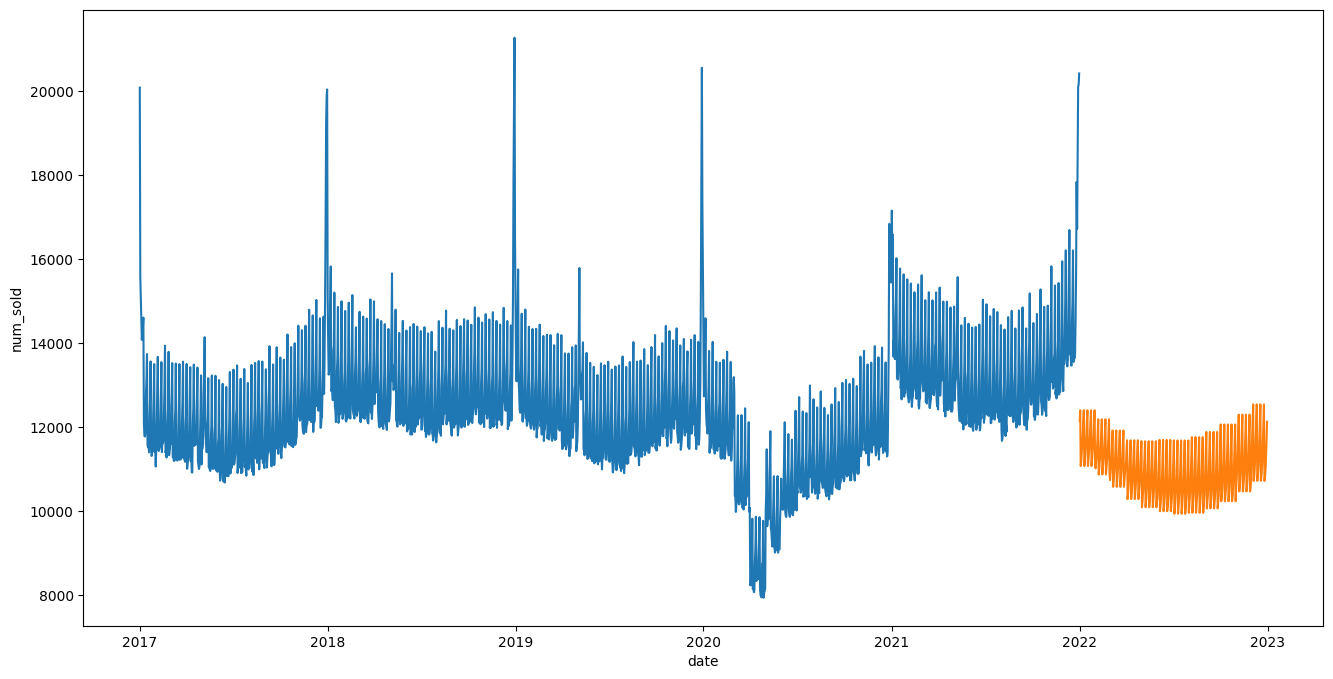

In [ ]:
fig = plt.figure(figsize=(16, 8))
sns.lineplot(data = train_data.groupby('date')['num_sold'].sum())
sns.lineplot(data = test_data.groupby('date')['num_sold'].sum())